# Analysis dataframe creater

In [15]:
import binance_helpers as bh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import model as m
import ui
import importlib
import time
from datetime import datetime, timedelta
client = bh.new_binance_client()
importlib.reload(m)

<module 'model' from '/Users/SunnyNie/Documents/Investing/metagame/model.py'>

In [16]:
trades = pd.read_csv("data/trades.csv", index_col=0, parse_dates=True)
trades = trades.iloc[-5000:]

## Downloading before and after

In [18]:
def get_filtered_dataframe(klines):
        """filters columns and converts columns to floats and ints respectively"""
        df = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
        df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume', 'tb_base_av']]
        df = df.astype(np.float64)
        df["timestamp"] = df.timestamp.astype(np.int64)
        df['timestamp'] = list(map(lambda x: datetime.utcfromtimestamp(x/1e3), df.timestamp))
        df.set_index('timestamp', inplace=True)
        return df
    

def before(trades):

    df = pd.DataFrame(columns = ["open", "high", "low", "close", "volume", "tb_base_av"], index=trades.resample("1T").mean().index)
    i = 0
    length = len(trades)
    for i in range(length):
        s = trades.iloc[i].name
        e = s+timedelta(hours=0)
        ss = (s-timedelta(hours=2)).strftime("%d %b %Y %H:%M:%S")
        es = (e-timedelta(hours=0, minutes=1)).strftime("%d %b %Y %H:%M:%S")
        try:
            if trades.iloc[i].trades is np.NaN: continue
            name = trades.iloc[i].trades.upper()+"USDT"
            klines = client.get_historical_klines(symbol=name, interval = "1m", start_str=ss, end_str=es)
            try:
                d_ = get_filtered_dataframe(klines)
                df.update(d_)
            except:
                print(f"Warning: failed for function #{j} for trades.iloc[{i}]")
        except Exception as e:
            print(f"Warning: unable to get for trades.iloc[{i}] -- {name} --{e}")

        i += 1
        ui.printProgressBar(i, length)
    df.to_csv("data/before.csv")
    return df

def after(trades):

    df = pd.DataFrame(columns = ["open", "high", "low", "close", "volume", "tb_base_av"], index=trades.resample("1T").mean().index)
    i = 0
    length = len(trades)
    for i in range(length):
        s = trades.iloc[i].name
        e = s+timedelta(hours=0)
        ss = (s-timedelta(hours=0)).strftime("%d %b %Y %H:%M:%S")
        es = (e+timedelta(hours=1, minutes=59)).strftime("%d %b %Y %H:%M:%S")
        try:
            if trades.iloc[i].trades is np.NaN: continue
            name = trades.iloc[i].trades.upper()+"USDT"
            klines = client.get_historical_klines(symbol=name, interval = "1m", start_str=ss, end_str=es)
            try:
                d_ = get_filtered_dataframe(klines)
                df.update(d_)
            except:
                print(f"Warning: failed for function #{j} for trades.iloc[{i}]")
        except Exception as e:
            print(f"Warning: unable to get for trades.iloc[{i}] -- {name} --{e}")

        i += 1
        ui.printProgressBar(i, length)
    df.to_csv("data/after.csv")
    return df

In [19]:
df = before(trades)

 |██████████████████████████████████████████████████| 100.0% 


In [20]:
df_ = after(trades)

 |██████████████████████████████████████████████████| 100.0% 


## Read csv

In [21]:
b = pd.read_csv("data/before.csv", index_col=0, parse_dates=True)
a = pd.read_csv("data/after.csv", index_col=0, parse_dates=True)

## Analysis

In [22]:
def get_average_result(t, a):
    r = []
    for i in range(-len(t), -1):
        m = a.loc[t.iloc[i].name:trades.iloc[i+1].name-timedelta(minutes=1)]
        r.append(-(m.close.mean()-m.iloc[0].open)/m.iloc[0].open)
    r.append(None)
    return r

In [23]:
trades['result'] = get_average_result(trades, a)

In [24]:
trades.to_csv("data/tradesr.csv")

In [14]:
t = trades[trades['result']<-0.01]

In [28]:
def analyze(trades, b, func):
    result = []
    for _ in range(len(func)):
        result.append([])
    i = 0
    length = len(trades)
    for i in range(length):
        s = trades.iloc[i].name - timedelta(hours=2)
        e = s+timedelta(hours=1, minutes=59)

        for j in range(len(func)):
            try:
                result[j].append(func[j](b.loc[s:e]))
            except:
                print(f"Warning: failed for function #{j} for trades.iloc[{i}]")
                result[j].append(0)

        i += 1
        ui.printProgressBar(i, length)
    return result

In [17]:
def a1(t):
    s = (t.high-t.low).mean()
    h = int(len(t)/2)
    return (t.iloc[h:].high-t.iloc[h:].low).mean()/s
def a2(t):
    s = (t.high-t.low).mean()
    h = int(2*len(t)/3)
    return (t.iloc[h:].high-t.iloc[h:].low).mean()/s
def a3(t):
    s = (t.high-t.low).mean()
    h = int(3*len(t)/4)
    return (t.iloc[h:].high-t.iloc[h:].low).mean()/s
def b1(t):
    h = int(len(t)/2)
    return t.iloc[h:].volume.mean()/t.volume.mean()
def b2(t):
    h = int(2*len(t)/3)
    return t.iloc[h:].volume.mean()/t.volume.mean()
def b3(t):
    h = int(3*len(t)/4)
    return t.iloc[h:].volume.mean()/t.volume.mean()
def c1(t):
    h = int(len(t)/2)
    return (t.iloc[h:].tb_base_av/t.iloc[h:].volume).mean()
def c2(t):
    h = int(2*len(t)/3)
    return (t.iloc[h:].tb_base_av/t.iloc[h:].volume).mean()
def c3(t):
    h = int(3*len(t)/4)
    return (t.iloc[h:].tb_base_av/t.iloc[h:].volume).mean()
def d1(t):
    h = int(len(t)/2)
    return (t.iloc[h:].tb_base_av/t.iloc[h:].volume).mean()/(t.tb_base_av/t.volume).mean()
def d2(t):
    h = int(2*len(t)/3)
    return (t.iloc[h:].tb_base_av/t.iloc[h:].volume).mean()/(t.tb_base_av/t.volume).mean()
def d3(t):
    h = int(3*len(t)/4)
    return (t.iloc[h:].tb_base_av/t.iloc[h:].volume).mean()/(t.tb_base_av/t.volume).mean()

In [18]:
def e1(t):
    return t.iloc[-1].close/max(t.high)
def e2(t):
    return min(t.low)/t.iloc[-1].close
def e3(t):
    return min(t.low)/max(t.high)
def f1(t):
    h = int(1*len(t)/2)
    return sum(t.iloc[h:].volume)/sum(t.volume)
def f2(t):
    h = int(2*len(t)/3)
    return sum(t.iloc[h:].volume)/sum(t.volume)
def f3(t):
    h = int(3*len(t)/4)
    return sum(t.iloc[h:].volume)/sum(t.volume)
def g1(t):
    return max(t.high-t.low)/t.iloc[-1].close
def g2(t):
    return max(t.high-t.low)/(t.high-t.low).mean()
def g3(t):
    return max(t.high-t.low)/t.iloc[0].close

In [43]:
def macd(t):
    exp1 = t.close.ewm(span=12, adjust=False).mean()
    exp2 = t.close.ewm(span=26, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=9, adjust=False).mean()
    m = (macd-exp3)
    return m[-1]/max(m)

In [44]:
r = analyze(trades, b, [macd]) #[a1, a2, a3, b1, b2, b3, c1, c2, c3, d1, d2, d3]
# e2<0.9

 |██████████████████████████████████████████████████| 100.0% 


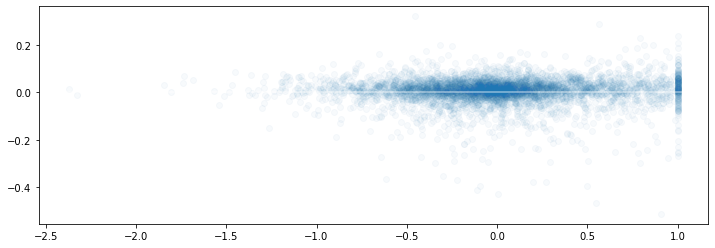

In [47]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(r[0], trades['result'], alpha=0.03)
# ax.set_xscale('log')
ax.axhline(0, c="white", alpha=0.5)

In [46]:
r[0][-1]

-0.06307020986939642

In [225]:
t = trades[:]
pd.options.mode.chained_assignment = None
t['a'] = r[1]
t['b'] = r[1]
t = t[t['a']>0.8]

In [226]:
print(f"mean: {round(100*trades.result.mean(), 2)}%, median: {round(100*trades.result.median(), 2)}%, winrate: {round(100*len(trades[trades.result>0].result)/len(trades), 2)}%")
print(f"mean: {round(100*t.result.mean(), 2)}%, median: {round(100*t.result.median(), 2)}%, winrate: {round(100*len(t[t.result>0].result)/len(t), 2)}%, length: {len(t)}")

mean: 0.71%, median: 1.23%, winrate: 64.88%
mean: 0.96%, median: 1.64%, winrate: 66.87%, length: 1343


In [227]:
print(f"mean: {round(100*trades.target.mean(), 2)}%, median: {round(100*trades.target.median(), 2)}%, winrate: {round(100*len(trades[trades.target>0].target)/len(trades), 2)}%")
print(f"mean: {round(100*t.target.mean(), 2)}%, median: {round(100*t.target.median(), 2)}%, winrate: {round(100*len(t[t.target>0].target)/len(t), 2)}%, length: {len(t)}")

mean: 1.02%, median: 1.8%, winrate: 65.2%
mean: 1.35%, median: 2.41%, winrate: 67.61%, length: 1343


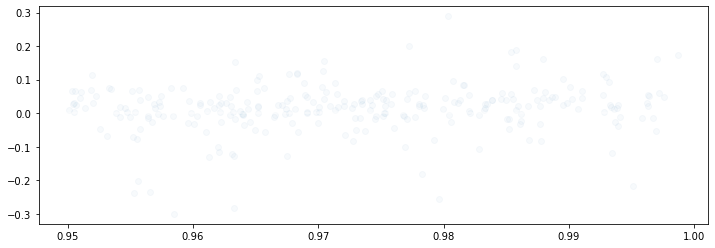

In [224]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(t['b'], t['result'], alpha=0.03)
# ax.set_xscale('log')
ax.axhline(0, c="white", alpha=0.5)

<AxesSubplot:xlabel='timestamp'>

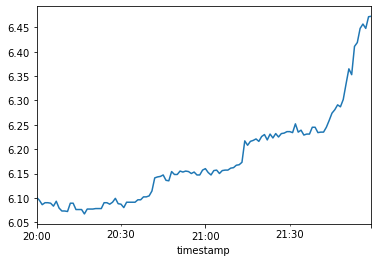

In [54]:
b.loc[trades.iloc[-3].name:trades.iloc[-2].name-timedelta(minutes=1)].close.plot()

In [22]:
a.loc[trades.iloc[0].name:trades.iloc[1].name].close.mean()

0.19393677685950408

In [26]:
trades.iloc[-3:]

,trades,pret,target
timestamp,,,
2022-02-05 20:00:00,poly,0.083114,-0.003911
2022-02-05 22:00:00,uma,0.061165,0.010556
2022-02-06 00:00:00,gala,0.117593,-0.169426
